# MLP Training and Testing

Sample code to train and test a simple MLP with CSI data extracted from a variational autoencoder.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF log and warnings

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import keras
import keras.backend as K

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import dirichlet

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
!mkdir results

np.random.seed(0) # predictable random numbers, for demonstration only

# computes golden ratio for figures
def goldenrect(h):
    return (h * 1.618, h)

def summary_clf(y_test, predicted, y_score, _labels = None):
    print(classification_report(y_test, predicted, labels= _labels))

### Download the pre-processed dataset

In [3]:
!wget https://zenodo.org/record/7983057/files/latent_space_dataset.zip
!unzip -o latent_space_dataset.zip
!rm latent_space_dataset.zip

--2023-05-30 16:07:17--  https://zenodo.org/record/7983057/files/latent_space_dataset.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9808431 (9,4M) [application/octet-stream]
Saving to: ‘latent_space_dataset.zip’

latent_space_datase 100%[===================>]   9,35M  1,56MB/s    in 6,2s    

2023-05-30 16:07:24 (1,51 MB/s) - ‘latent_space_dataset.zip’ saved [9808431/9808431]

Archive:  latent_space_dataset.zip
   creating: latent_space_dataset/
  inflating: __MACOSX/._latent_space_dataset  
  inflating: latent_space_dataset/single_antenna_3.pkl  
  inflating: __MACOSX/latent_space_dataset/._single_antenna_3.pkl  
  inflating: latent_space_dataset/single_antenna_2.pkl  
  inflating: __MACOSX/latent_space_dataset/._single_antenna_2.pkl  
  inflating: latent_space_dataset/single_antenna_0_squat.pkl  
  inflating: __MACOSX/latent_space_dataset/._single_a

## Load dataset

The `latent_space_dataset` directory contains some datasets of CSI that have been already processed by the VAE. The VAE has been trained without any information about the target classes; it just tries to minimize reconstruction loss + KL loss.

The Encoder in the VAE maps sequences of CSI into **2 Gaussian variables** with parameters (z_mean, z_log_var).

More in detail, from the dataset we load `data` and `labels`.
- `data`: every element is a 4-tuple with the values (z1_mean, z2_mean, z1_log_var, z2_log_var)
- `labels`: 5 different classes, labelled with integers from 0 to 4 (0 = walk, 1 = run, 2 = jump, 3 = sit, 4 = empty)

Available datasets:
- `single_antenna`: data of just antenna 1, normalized wrt to the maximum value over the entire dataset (four antennas are available, numbered from 0 to 3)
- `four_antennas`: data of the four antennas fused together, normalized wrt to the maximum value over the entire dataset
- `four_antennas_latent_space_3`: same as `four_antennas`, but the CSI is mapped onto 3 Gaussian variables; hence, every element in `data` is a 6-tuple with the values (z1_mean, z2_mean, z3_mean, z1_log_var, z2_log_var, z3_log_var)

In [4]:
semantic_classes = ["Walk", "Run", "Jump", "Sit", "Empty"]

In [5]:
def load_experiment(name, _test_size = 0.2, _random_state = 42):
    data = None
    labels = None
    
    # features columns
    fcolumns = ['mu1','mu2','sigma1','sigma2']
    
    # check which experiments we wants to load
    if name == "No-Fused-1":
        with open('./latent_space_dataset/single_antenna_0.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-2":
        with open('./latent_space_dataset/single_antenna_1.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-3":
        with open('./latent_space_dataset/single_antenna_2.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-4":
        with open('./latent_space_dataset/single_antenna_3.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "Early-Fusing":
        with open('./latent_space_dataset/four_antennas.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "Early-Fusing3": # Same as Early-Fusing, but mapping the input data onto 3-dim Gaussian variables
        with open('./latent_space_dataset/four_antennas_latent_space_3.pkl', 'rb') as f:
            fcolumns = ['mu1','mu2', 'mu3', 'sigma1','sigma2','sigma3']
            data, labels = pickle.load(f)
    elif name == "Delayed-Fusing":
        fcolumns=[
                      'mu1_0','mu2_0','sigma1_0','sigma2_0',
                      'mu1_1','mu2_1','sigma1_1','sigma2_1',
                      'mu1_2','mu2_2','sigma1_2','sigma2_2',
                      'mu1_3','mu2_3','sigma1_3','sigma2_3']
        with open('./latent_space_dataset/four_antennas.pkl', 'rb') as f:
            data, labels = pickle.load(f)
        for ant in range(1,4):
            with open(f'./latent_space_dataset/single_antenna_{ant}.pkl', 'rb') as f:
                data_tmp, labels_tmp = pickle.load(f)
            data = np.concatenate((data, data_tmp), axis=1)

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)
    
    # let's load into a dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    # standard scaler
    scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])
    
    # test/train split 
    X_train, X_test, y_train, y_test = train_test_split(df[fcolumns], df['signal'], 
                                                        test_size=_test_size, 
                                                        random_state=_random_state, 
                                                        stratify=df['signal'])
    
    
    # one-hot-encoding
    y_train_dummy = keras.utils.np_utils.to_categorical(y_train)
    y_test_dummy = keras.utils.np_utils.to_categorical(y_test)
    
    return X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns
    

## EDL models

### Auxiliary Functions

In [6]:
num_epochs_annealing = 1
num_classes = 5

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = 5):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def load_edl_experiment(name):
    keras.models.load_model(name)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test(name):
    print(name)
    X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment(name)
    mlp_edl = keras.models.load_model("KERAS_model_%s" % name, compile=False)
    mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(K.argmax(mlp_edl.predict(X_test), axis=1))
    print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))
    cm = confusion_matrix(y_test, y_predictions_edl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")
    cmdisp.figure_.savefig("results/CM-%s.pdf" % name, bbox_inches='tight')

In [7]:
def run_edl_experiment(name, _X_train, _y_train_dummy):

    model_edl = None
    num_classes = 5
    
    if name == "Delayed-Fusing":
        num_epochs_annealing = 3
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(16,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5, activation='softplus'))

    elif name == "Early-Fusing":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.001
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    elif name == "Early-Fusing3":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    else:
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(4, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])
    
    # Define early stop policy
    early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[GetEpochs(), early_stop_cb],
      shuffle=True)

    model_edl.save("KERAS_model_%s" % name)


### Define and run the experiments

In [8]:
experiments = []
for i in range(1, 5):
    experiments.append("No-Fused-%d" % i)
experiments.append("Early-Fusing")
experiments.append("Early-Fusing3")
experiments.append("Delayed-Fusing")

print(f'Experiments to run: {experiments}')

Experiments to run: ['No-Fused-1', 'No-Fused-2', 'No-Fused-3', 'No-Fused-4', 'Early-Fusing', 'Early-Fusing3', 'Delayed-Fusing']


Either train the models from scratch or use the ones already available.

In [9]:
train_from_scratch = False

if train_from_scratch:
    for exp in experiments:
        print(exp)
        print("Loading data")
        X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment(exp)
        
        print("Fit model and save")
        run_edl_experiment(exp, X_train, y_train_dummy)
else:
    !wget https://zenodo.org/record/7983057/files/KERAS_models.zip
    !unzip -o KERAS_models.zip
    !rm KERAS_models.zip

--2023-05-30 16:07:25--  https://zenodo.org/record/7983057/files/KERAS_models.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144770 (141K) [application/octet-stream]
Saving to: ‘KERAS_models.zip’

KERAS_models.zip    100%[===================>] 141,38K  --.-KB/s    in 0,1s    

2023-05-30 16:07:26 (1,20 MB/s) - ‘KERAS_models.zip’ saved [144770/144770]

Archive:  KERAS_models.zip
   creating: KERAS_model_Delayed-Fusing/
  inflating: __MACOSX/._KERAS_model_Delayed-Fusing  
  inflating: KERAS_model_Delayed-Fusing/fingerprint.pb  
  inflating: __MACOSX/KERAS_model_Delayed-Fusing/._fingerprint.pb  
  inflating: KERAS_model_Delayed-Fusing/keras_metadata.pb  
  inflating: __MACOSX/KERAS_model_Delayed-Fusing/._keras_metadata.pb  
   creating: KERAS_model_Delayed-Fusing/variables/
  inflating: __MACOSX/KERAS_model_Delayed-Fusing/._variables  
  inflating: KERAS_

No-Fused-1
361/361 [==============================] - 0s 295us/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2310
           1       0.84      0.96      0.90      2310
           2       0.99      0.94      0.96      2310
           3       0.97      0.93      0.95      2310
           4       0.94      0.98      0.96      2310

    accuracy                           0.93     11550
   macro avg       0.94      0.93      0.93     11550
weighted avg       0.94      0.93      0.93     11550

None
No-Fused-2
361/361 [==============================] - 0s 363us/step
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      2310
           1       0.73      0.97      0.83      2310
           2       0.99      0.94      0.96      2310
           3       0.99      0.99      0.99      2310
           4       1.00      1.00      1.00      2310

    accuracy                           0.92 

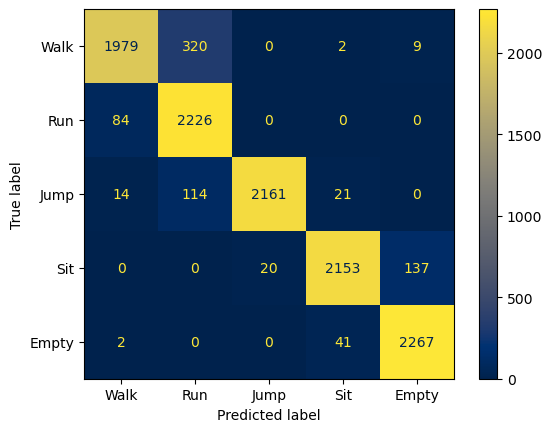

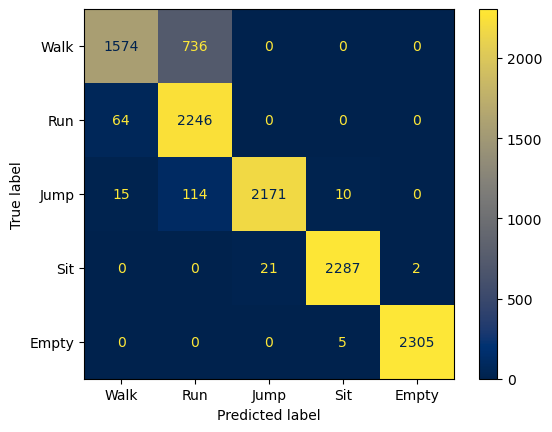

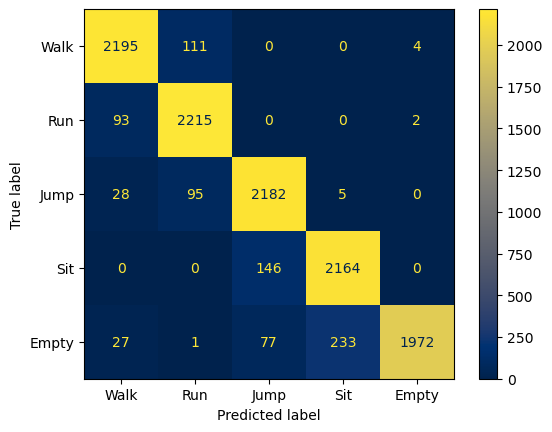

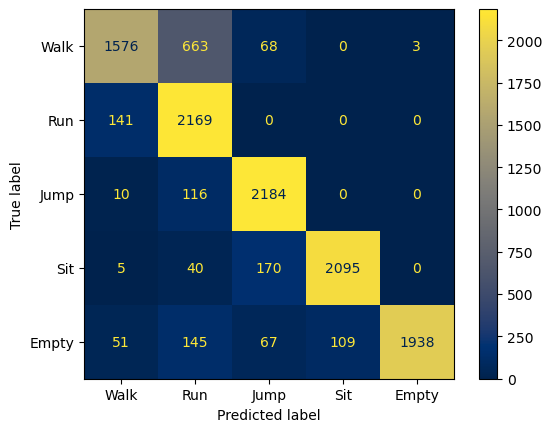

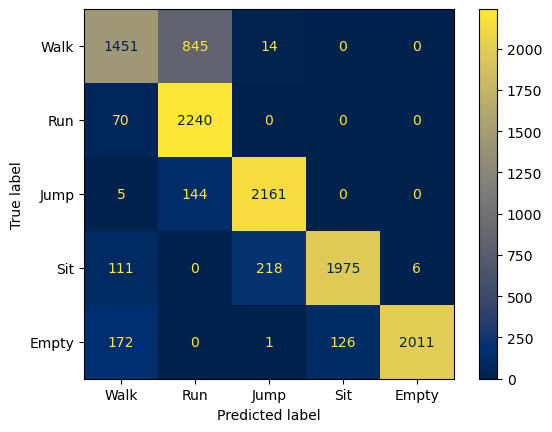

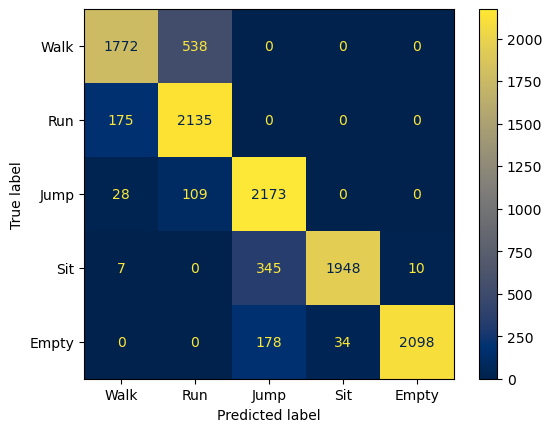

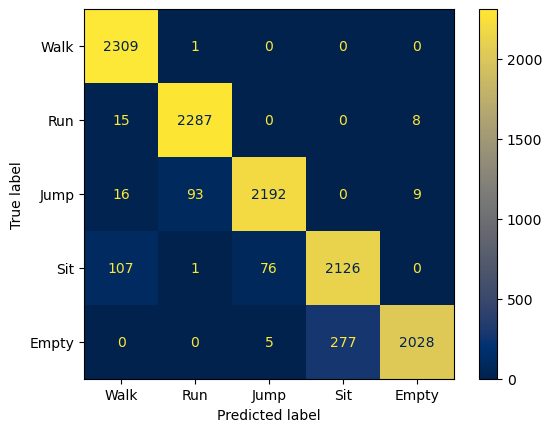

In [10]:
experiments_res = []
for i in range(1, 5):
   experiments_res.append("No-Fused-%d" % i)
experiments_res.append("Early-Fusing")
experiments_res.append("Early-Fusing3")
experiments_res.append("Delayed-Fusing")

for _e in experiments_res:
    results_test(_e)

## Decision tree model

In [11]:
%pip install dtreeviz
import dtreeviz


[notice] A new release of pip available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load experiment

In [12]:
exp = "Delayed-Fusing"
X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment(exp)

### Train the decision tree

In [13]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42, max_leaf_nodes=6)
clf = clf.fit(scaler.inverse_transform(X_train), y_train)
predicted = clf.predict(scaler.inverse_transform(X_test))
y_score = clf.predict_proba(scaler.inverse_transform(X_test))[:,1]

summary_clf(y_test, predicted, y_score)

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2310
           1       0.74      0.89      0.81      2310
           2       0.98      0.94      0.96      2310
           3       0.99      0.97      0.98      2310
           4       1.00      1.00      1.00      2310

    accuracy                           0.91     11550
   macro avg       0.92      0.91      0.91     11550
weighted avg       0.92      0.91      0.91     11550



### Plot the confusion matrix

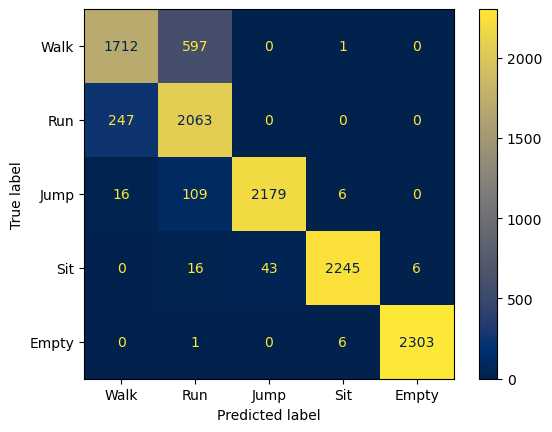

In [14]:
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
cmdisp = disp.plot(cmap="cividis")
cmdisp.figure_.savefig("results/CM-DT.pdf", bbox_inches='tight')

### Visualize the tree model

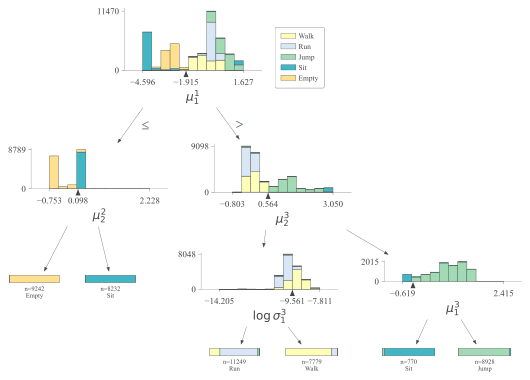

In [15]:
## This might need additional packages on your system (e.g., graphviz)

viz_model = dtreeviz.model(clf,
                           X_train=scaler.inverse_transform(X_train), y_train=y_train,
                           feature_names = ['$\mu_1^1$','$\mu_2^1$','$\log \sigma_1^1$','$\log \sigma_2^1$',
                                            '$\mu_1^2$','$\mu_2^2$','$\log \sigma_1^2$','$\log \sigma_2^2$',
                                            '$\mu_1^3$','$\mu_2^3$','$\log \sigma_1^3$','$\log \sigma_2^3$',
                                            '$\mu_1^4$','$\mu_2^4$','$\log \sigma_1^4$','$\log \sigma_2^4$'
                                            ],
                           class_names=semantic_classes)

v = viz_model.view(ticks_fontsize=12,
                   label_fontsize=16,
                   fontname='Times New Roman',
                   instance_orientation="TD",
                   leaftype='barh',
                  )

v

In [16]:
v.save("results/delayedfusedtree-bar.svg")

## EDL generalization to unseen class (squat)

We evaluate how the EDL model handles previously unseen cases by presenting a new activity class, namely squatting, to it.

First, we load the `Delayed-Fusing` model.

In [17]:
model = keras.models.load_model("KERAS_model_Delayed-Fusing", compile=False)

In [18]:
ood = None
fcolumns=[
    'mu1_0','mu2_0','sigma1_0','sigma2_0',
    'mu1_1','mu2_1','sigma1_1','sigma2_1',
    'mu1_2','mu2_2','sigma1_2','sigma2_2',
    'mu1_3','mu2_3','sigma1_3','sigma2_3']

for ant in range(0,4):
    with open(f'./latent_space_dataset/single_antenna_{ant}_squat.pkl', 'rb') as f:
        data_tmp, labels_tmp = pickle.load(f)
        if ood is None:
            ood = data_tmp
            continue
    ood = np.concatenate((ood, data_tmp), axis=1)

ood = pd.DataFrame(ood, columns=fcolumns)

In [19]:
ood

,mu1_0,mu2_0,sigma1_0,sigma2_0,mu1_1,mu2_1,sigma1_1,sigma2_1,mu1_2,mu2_2,sigma1_2,sigma2_2,mu1_3,mu2_3,sigma1_3,sigma2_3
0,1.097180,-0.013835,-11.644371,-13.035059,-0.936916,0.564219,-9.915048,-10.281840,0.550533,0.024934,-9.669416,-9.959284,0.042080,0.261159,-8.134630,-8.807738
1,1.094611,-0.021952,-11.676377,-13.068797,-0.927062,0.561808,-9.863350,-10.229851,0.538758,0.012082,-9.666197,-9.964521,0.014149,0.308180,-8.151798,-8.849463
2,1.084171,-0.016493,-11.694776,-13.081736,-0.913376,0.572650,-9.885822,-10.244368,0.526438,0.049620,-9.581347,-9.888138,0.005536,0.322678,-8.157092,-8.862329
3,1.055567,-0.014822,-11.687878,-13.067069,-0.914169,0.589824,-10.002766,-10.352306,0.521863,0.070632,-9.569378,-9.878483,-0.005656,0.341521,-8.163971,-8.879049
4,1.016454,-0.005744,-11.650020,-13.016640,-0.932410,0.583005,-10.023516,-10.379599,0.526706,0.062997,-9.614646,-9.919781,-0.010493,0.349663,-8.166945,-8.886275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69295,0.169216,1.701048,-10.761122,-11.235210,0.727913,1.383079,-14.047695,-13.382378,1.874866,0.260814,-11.229065,-10.595388,-1.450600,-1.666111,-9.335263,-9.105799
69296,0.158623,1.698407,-10.729864,-11.203279,0.747704,1.371437,-13.955519,-13.289252,1.877447,0.247085,-11.214081,-10.579739,-1.455437,-1.659412,-9.338328,-9.112396
69297,0.152794,1.699468,-10.695801,-11.168313,0.732580,1.361861,-13.992598,-13.330625,1.880136,0.247514,-11.152189,-10.517617,-1.455378,-1.665604,-9.338681,-9.109657
69298,0.152454,1.705191,-10.679537,-11.150091,0.735264,1.360001,-14.003714,-13.339978,1.879056,0.251157,-11.159549,-10.525328,-1.462654,-1.660599,-9.343616,-9.117375


In [20]:
for exp in ['Delayed-Fusing']:
    print(exp)
    print("Loading data")
    X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment(exp)

ood = scaler.transform(ood)

Delayed-Fusing
Loading data


361/361 [==============================] - 0s 300us/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2310
           1       0.96      0.99      0.97      2310
           2       0.96      0.95      0.96      2310
           3       0.88      0.92      0.90      2310
           4       0.99      0.88      0.93      2310

    accuracy                           0.95     11550
   macro avg       0.95      0.95      0.95     11550
weighted avg       0.95      0.95      0.95     11550

None
361/361 [==============================] - 0s 298us/step


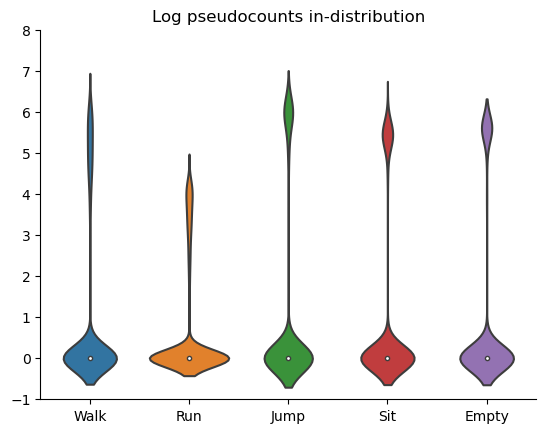

2166/2166 [==============================] - 1s 321us/step


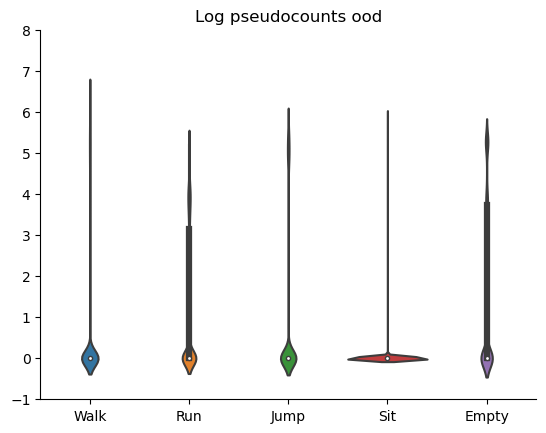

In [21]:
mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in model.predict(X_test)])
y_predictions_edl = np.array(K.argmax(model.predict(X_test), axis=1))
print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))

r = np.log(model.predict(X_test) + 1)
ax = sns.violinplot(data=pd.DataFrame(r))

ymin = -1
ymax = 8

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4], semantic_classes)
ax.set_title("Log pseudocounts in-distribution")
ax.set_ylim([ymin, ymax])
plt.savefig("results/LogPseudocountsINwoSQUAT.pdf", bbox_inches='tight')
plt.show()

r = np.log(model.predict(ood) + 1)
ax = sns.violinplot(data=pd.DataFrame(r))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4], semantic_classes)
ax.set_title("Log pseudocounts ood")
ax.set_ylim([ymin, ymax])
plt.savefig("results/LogPseudocountsSQUAT.pdf", bbox_inches='tight')
plt.show()
